In [1]:
import codecs
import json
import numpy as np
import sklearn

In [2]:
from Scripts.ProcessingEmbeddings import *
import Scripts.utils as utils

In [3]:
#Creating an embeddings object: 400k words, 50 dimensions
glove=Embeddings('Data/glove-wiki-gigaword-50.txt', gensim=False)
#glove_300=Embeddings('glove-wiki-gigaword-300')

Loading Data/glove-wiki-gigaword-50.txt embeddings
vectors shape: (400000, 50), word2idx length: 400000, vocab length: 400000


In [4]:
#Getting the attributes of the embeddings 
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

In [5]:
#Verifying the attributes: there shouldn't be any null values
np.isnan(vectors).any()

False

In [6]:
#Removing puntuation and numbers from the embeddings
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(vectors, word2idx, vocab)

100%|██████████| 400000/400000 [00:00<00:00, 614695.27it/s]


Size of limited vocabulary: 327185


In [37]:
#Checking if vector are normalized
np.apply_along_axis(np.linalg.norm, 1, vectors_cleaned)
#They are not!

array([4.96782699, 4.95609794, 4.9568709 , ..., 4.51387709, 4.40890635,
       3.25460327])

## Hard-Debias Algorithm

#### Preliminaries

In [38]:
from Scripts.HardDebias import *

In [39]:
#Gender specific vocabulary from Bolukbasi's paper.
gender_specific = []
female_vocab = []
male_vocab = []
with open('./Data/male_word_file.txt') as f:
    male_vocab = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        female_vocab.append(l.strip())

gender_specific = female_vocab+female_vocab

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))


In [40]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets={
    "gender" : [
    ['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
    ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'],['aunt', 'uncle']],
    
    "race":[
		["black", "caucasian", "asian", "hispanic"],
		["african", "caucasian", "asian", "hispanic"],
		["black", "white", "asian", "latino"],
		["africa", "europe", "asia", "mexico"],
		["africa", "america", "china", "latin-america"],
    ]
	}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], [
            "Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], [
            "grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], [
            "wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], [
            "brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman",
                                                        "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], [
            "fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], [
            "gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], [
            "his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], [
            "men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]],

    "race": [
        ["black", "caucasian", "asian"],
      	["african", "caucasian", "asian"],
      	["black", "white", "asian"],
      	["africa", "america", "asia"],
      	["africa", "america", "china"],
      	["africa", "europe", "asia"]
    ]}

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


In [10]:
#Lists of names for validation
#Adapted from Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
   
}
#Following Bolukbasi et al. Implementing notebook: https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
#names_group1 = [names[2 * i] for i in range(len(names) // 2)]
#names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]



In [11]:
#Preparing the definite sets for debiasing
def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])

## What's the better way to find the Bias direction
The success of hard debiasing algorithms lies on their capacity to find the appropriate bias direction. 

In [12]:
#Find the words in the female_vocab that are also in the embeddings
female_words_emb=[word for word in female_vocab if word in dict_vec_cleaned.keys()]
male_words_emb = [word for word in male_vocab if word in dict_vec_cleaned.keys()]

print('Number of female words in embeddings:', len(female_words_emb))
print('Number of male words in embeddings:', len(male_words_emb))


Number of female words in embeddings: 195
Number of male words in embeddings: 204


In [13]:
#getting the gender directions
gen_dir_centralized=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=True)
gen_dir=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=False)

#flattening them
gen_dir_centralized_flat=np.squeeze(gen_dir_centralized)
gen_dir_flat=np.squeeze(gen_dir)


Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components


In [14]:
#compute the similarity of a word through cosine similarity to the bias direction
def compute_similarity_to_bias_direction(dict_vec_cleaned, bias_direction):
    bias_direction = bias_direction / np.linalg.norm(bias_direction)
    similarity = {}
    for word in dict_vec_cleaned.keys():
        dict_vec_cleaned[word]=dict_vec_cleaned[word]/np.linalg.norm(dict_vec_cleaned[word])
        similarity[word]=utils.cosine_similarity(bias_direction, dict_vec_cleaned[word])
    return similarity


In [15]:
from Scripts.Evaluation import compute_gender_simple_bias, compute_similarity_to_bias_direction
similarity=compute_similarity_to_bias_direction(dict_vec_cleaned, gen_dir_flat)
similarity_centralized=compute_similarity_to_bias_direction(dict_vec_cleaned, gen_dir_centralized_flat)
simple_gender_bias=compute_gender_simple_bias(dict_vec_cleaned, dict_vec_cleaned['he'], dict_vec_cleaned['she'])

In [41]:
from operator import itemgetter
#function to get the most biased words in dict_vec_cleaned rated my similarity to the bias direction
def get_most_biased_words_similarity(similarity, n_words=2500):
    sorted_similarity =sorted(similarity.items(), key=itemgetter(1), reverse=True)
    biased_words = [word for word, bias in sorted_similarity[:n_words*2]]
    neutral_words = [word for word, bias in sorted_similarity[-n_words:]]
    return biased_words, neutral_words

In [75]:
biased_words, neutral_words=get_most_biased_words_similarity(similarity, n_words=40000)


In [76]:
#count how many female_words_emb and male_words_emb are in the biased_words
def count_gendered_words_in_most_biased(female_words, male_words, biased_words):
    count_female=0
    count_male=0
    data={}
    for word in set(female_words):
        if word in set(biased_words):
            count_female+=1

    for word in set(male_words):
        if word in set(biased_words):
            count_male+=1
    
    data.update({'count_female': count_female, 'proportion_female': count_female/len(female_words),
                     'count_male': count_male, 'proportion_male': count_male/len(male_words)})
    return data

In [77]:
count_gendered_words_in_most_biased(female_words_emb, male_words_emb, biased_words)


{'count_female': 73,
 'proportion_female': 0.37435897435897436,
 'count_male': 63,
 'proportion_male': 0.3088235294117647}

In [78]:
biased_words_centralized, neutral_words_centralized=get_most_biased_words_similarity(similarity_centralized, n_words=40000)
count_gendered_words_in_most_biased(female_words_emb, male_words_emb, biased_words_centralized)

{'count_female': 121,
 'proportion_female': 0.6205128205128205,
 'count_male': 67,
 'proportion_male': 0.3284313725490196}

In [79]:
_, _, female_simple, male_simple, _ = utils.getting_biased_words(
    simple_gender_bias, def_sets['gender'], 40000, word2idx)

count_gendered_words_in_most_biased(female_words_emb, male_words_emb,female_simple+male_simple )

{'count_female': 119,
 'proportion_female': 0.6102564102564103,
 'count_male': 76,
 'proportion_male': 0.37254901960784315}

#### Now let's plot the results

In [83]:
import pandas as pd
#get a dataframe with the bias scores of the female_words_emb and male_words_emb in the similarity, similarity_centralized and simple_gender_bias
def get_df_bias_scores(word_list, similarity, similarity_centralized,simple_bias_score):
    scores={}
    for word in word_list:
        scores[word] = {"similarity_score": similarity[word],
                        "centralized_similarity_score": similarity_centralized[word],
                        "simple_bias_score": simple_bias_score[word]}
    df=pd.DataFrame.from_dict(scores, orient='index')
    return df



In [96]:
df_female=get_df_bias_scores(female_words_emb, similarity, similarity_centralized,simple_gender_bias)
df_male=get_df_bias_scores(male_words_emb, similarity, similarity_centralized,simple_gender_bias)

In [98]:
#sort the dataframe according to the simple_gender_bias column
most_female_bias=df_female.sort_values(by=['simple_bias_score'], ascending=False, inplace=True)
most_male_bias=df_male.sort_values(by=['simple_bias_score'], ascending=True, inplace=True)

In [103]:
#plot a bar plot of the top 20 most biased words with all the scores of the three methods
import plotly_express as px

def plot_top_biased_words(df, n_words=20):
    df_top=df.head(n_words)
    df_top=df_top.reset_index()
    df_top=df_top.rename(columns={'index': 'word'})
    df_top=df_top.melt(id_vars=['word'], var_name='score_type', value_name='score')
    fig = px.bar(df_top, x="word", y="score", color="score_type", barmode="group")
    fig.show()


plot_top_biased_words(df_female, n_words=20)


In [95]:
df_female

,similarity_score,centralized_similarity_score,simple_bias_score
diva,0.372622,0.421970,0.270451
fiancee,0.395955,0.443614,0.253809
aunt,0.504109,0.438532,0.252506
girlfriend,0.487989,0.387773,0.236123
womb,0.267250,0.521725,0.233420
...,...,...,...
sororities,0.254547,0.090713,-0.030896
doe,0.066211,0.110974,-0.032958
headmistresses,0.365570,0.016649,-0.053225
landlords,0.058222,0.177305,-0.083148


In [64]:
#get a histogram of the similarity.values()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_histogram(similarity, title):
    plt.hist(similarity.values())
    plt.title(title)
    plt.show()

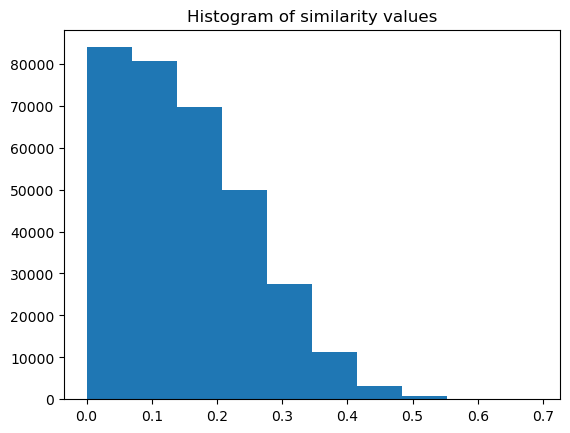

In [65]:
plot_histogram(similarity, 'Histogram of similarity values')

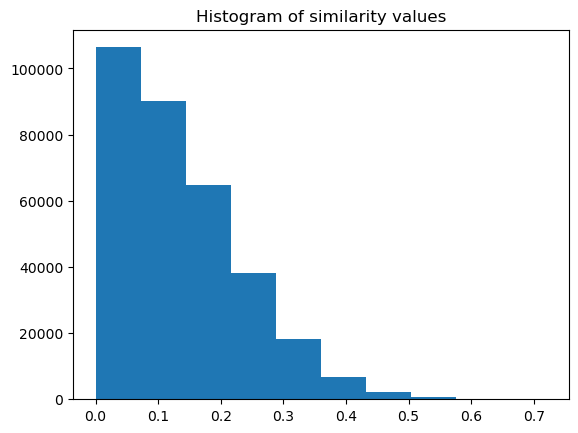

In [80]:
plot_histogram(similarity_centralized, 'Histogram of centralized similarity values')


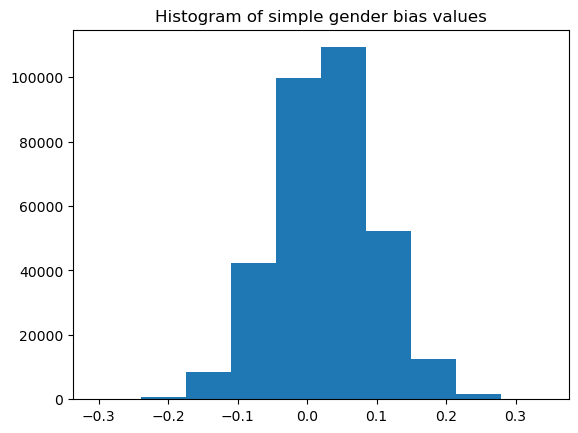

In [82]:
plot_histogram(simple_gender_bias, 'Histogram of simple gender bias values')


In [20]:
#get the words in similirity that have values 0
def get_words_with_value_zero(similarity):
    words=[]
    for word in similarity.keys():
        if np.allclose(similarity[word],0.5):
            words.append(word)
    return words

In [21]:
get_words_with_value_zero(similarity)

['mcf']

## Evaluation of Slight changes to the algorithm

In [ ]:
from Scripts.Visualization import *
from Scripts.Evaluation import *

### Setting up parameters and combinations

In [ ]:
# Importing the dataset with all parameter combinations: 
# norm_direction is a parameter that determines whether the bias direction is normalized or not
# normalize is a parameter that determines whether the word vectors are normalized before or after debiasing
# centralize is a parameter that determines whether the word vectors are centered before using PCA to find the bias subspace
import pandas as pd
parameters = pd.read_csv('Data/all_parameter_combinations.csv', header=0)
parameters


In [ ]:
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']
occupations = ['assistant', 'secretary', 'data scientist', 'scientist', 'politician', 'janitor', 'hairdresser', 'teacher', 'bartender', 'midwife', 'doctor', 'ballerina', 'dancer', 'pediatrician', 'surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists', 'carpenter', 'clerk', 'manager', 'supervisor', 'driver',
               'software developer', 'lawyer', 'pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro', 'lecturer', 'salesperson', 'homemaker', 'receptionist', 'librarian', 'nanny', 'bookkeeper', 'stylist', 'housekeeper', 'guidance counselor', 'skipper', 'protege', 'philosopher', 'captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher', 'pilot', 'boss']


In [ ]:
# gets the debiased vectors for all the 12 possible scenarios and stores them on a dataframe
def get_debiased_vectors(vectors, dict_vectors, word2idx_cleaned,
                         vocab_cleaned,
                         equalizing_lists,
                         def_set, parameters_df):
    grand_dictionary = {}
    #loop over indexes of the df
    for i in range(len(parameters_df)):
        #run the hard_debias function with the parameters of the row and generate a dictionary with the results: key=index, value:dictionary, key=name (vectors, vocab, word2idx), value: the result of the function
        debiased_vectors, debiased_vocab, debiased_word2idx, debiased_dict= hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists, 
                             def_set,
                             1,
                             normalize_dir=parameters_df.iloc[i][0],
                             normalize=parameters_df.iloc[i][1],
                             centralizing=parameters_df.iloc[i][2])
       
        #add the variables to the grand dictionary
        grand_dictionary[i] = {'vectors': debiased_vectors, 'vocab':debiased_vocab, 'word2idx':debiased_word2idx, 'dict':debiased_dict}
                    
        
    return grand_dictionary

In [ ]:
grand_dict=get_debiased_vectors(vectors, dict_vectors, word2idx_cleaned,
                     vocab_cleaned,
                     equalizing_lists['gender'],
                     def_set_gender, parameters)


### Bias Pre-Post of selected words. 
Using the original and debiased vectors, I calculate bias scores in two ways: 
1. Simple Bias Score: cos(v, she_embed)-cos(v, he_embed) for every v in the vocabulary
2. Direct bias score: following Bolukbasi et al. 2016

With this, I get a measure of the debiasing effects per word or the chosen list. 

In [ ]:
gender_bias_original = compute_gender_simple_bias(
    dict_vec_cleaned, he_embed, she_embed)

def get_debiased_vectors_scores_plots(grand_dict,dict_vectors,vocab_cleaned,parameters_df,he_embed,she_embed):
    scores_dictionary = {}
    
    #loop over indexes of the df
    for i in range(len(parameters_df)):
        #debiased_vectors=grand_dict[i]['vectors'] 
        debiased_vocab=grand_dict[i]['vocab']
        #debiased_word2idx=grand_dict[i]['word2idx']
        debiased_dict = grand_dict[i]['dict']

        # Using the gender bias function to compute the bias of all the words in the limited dataset
        #We create a dictionary with the word as key and the bias as value
        gender_bias_after_debiasing= compute_gender_simple_bias(debiased_dict, he_embed, she_embed)
        
        gender_direction = identify_bias_subspace(dict_vectors, def_set_gender, 1, centralizing=parameters_df.iloc[i][2])
        if parameters_df.iloc[i][0]:
            gender_direction = utils.normalize(gender_direction)
        
        #use compute_direct_bias to get the scores
        direct_gender_bias_original = compute_direct_bias(
            dict_vectors, vocab_cleaned, gender_direction)
        direct_gender_bias_debiased= compute_direct_bias(debiased_dict, vocab_cleaned, gender_direction)
        
        scores_dictionary[i] = {'simple_bias': gender_bias_after_debiasing,
                                'direct_bias_original': direct_gender_bias_original, 
                                'direct_bias_debiased': direct_gender_bias_debiased}
    return scores_dictionary


In [ ]:
scores_dictionary = get_debiased_vectors_scores_plots(
    grand_dict,dict_vectors,vocab_cleaned, parameters, he_embed, she_embed)


In [ ]:
#Function to get a bar plot comparing pre-post scores for chosen words
def getting_plots_simple_scores(grand_dict,test_words, gender_bias_original, scores_dictionary, parameters_df):
    for i in range(len(scores_dictionary)):
        debiased_vocab=grand_dict[i]['vocab']
        gender_bias_debiased=scores_dictionary[i]['simple_bias']
        bias_df = get_bias_score_df_from_list(
            gender_bias_original, gender_bias_debiased, test_words, vocab_cleaned, debiased_vocab)
        print("______________________________________")
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        plot_bias_bar(bias_df, plot_title="Exp_"+str(i), words_title='words')


In [ ]:
#Plots for occupations
getting_plots_simple_scores(grand_dict,occupations,gender_bias_original,scores_dictionary, parameters)

In [ ]:
def getting_plots_direct_scores(grand_dict, test_words, scores_dictionary, parameters_df):
    for i in range(len(scores_dictionary)):
        debiased_vocab = grand_dict[i]['vocab']
        direct_gender_bias_original = scores_dictionary[i]['direct_bias_original']
        direct_gender_bias_debiased=scores_dictionary[i]['direct_bias_debiased']
        bias_df = get_bias_score_df_from_list(
            direct_gender_bias_original, direct_gender_bias_debiased, test_words, vocab_cleaned, debiased_vocab)
        print("______________________________________")
        print('Experiment_'+str(i), ', normalize_direction:',
              parameters_df.iloc[i][0], ', normalize_vectors:', parameters_df.iloc[i][1], ', centralize:', parameters_df.iloc[i][2])
        plot_bias_bar_direct_bias(
            bias_df, plot_title="Exp_"+str(i), words_title='words')


In [ ]:
getting_plots_direct_scores(grand_dict,occupations,scores_dictionary, parameters)

## Visualizing Clusters of feminine and masculine words
Debiasing algorithms are tested through the visualization of the feminine vs masculine clusters. When the clusters are very mingled together, it is said that the debiasing algorithm was successful (as the clusters are no longer linearly separable).

I plotted the clusters for all the experiments and interestingly, there are barely any differences between them. I'll still have to check whether the clustering algorithm is working properly. 


In [ ]:
c_w2i, c_vocab, female_words, male_words, y_true=utils.getting_biased_words(gender_bias_original, def_sets['gender'], 1000, word2idx)

In [ ]:
female_vocab_emb= list(w for w in female_vocab if w in vocab_cleaned)
male_vocab_emb= list(w for w in male_vocab if w in vocab_cleaned)

In [ ]:
def visualizing_all_clusters(grand_dict,parameters_df,word_list, y_true): 
    for i in range(len(parameters_df)):
        debiased_vectors=grand_dict[i]['vectors'] 
        #debiased_vocab=grand_dict[i]['vocab']
        debiased_word2idx=grand_dict[i]['word2idx']
        #debiased_dict = grand_dict[i]['dict']
        gendered_vectors = utils.extract_vectors(
            word_list, debiased_vectors, debiased_word2idx)

        print('Experiment_'+str(i), ', normalize_direction:',
          parameters_df.iloc[i][0], ', normalize_vectors:', parameters_df.iloc[i][1], ', centralize:', parameters_df.iloc[i][2])

        cluster_and_visualize(word_list,gendered_vectors, title=('Glove_Exp'+str(i)), y_true=y_true)


In [ ]:
gendered_vectors = utils.extract_vectors(
    male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      gendered_vectors, 'GloVe_original', y_true)


In [ ]:
visualizing_all_clusters(grand_dict, parameters,
                         male_words + female_words, y_true)


### MAC Scores
The Mean Average Cosine Similarity (MAC) developed by Manzini et al. allows to quantify how big the bias removal was: the closer the score is to one, the largest, the removal. 

In [ ]:
targets = [["he", "she"],
           ["his", "hers"],
           ["son", "daughter"],
           ["father", "mother"],
           ["male", "female"],
           ["boy", "girl"],
           ["uncle", "aunt"]]

Attributes = [["manager", "executive", "doctor", "lawyer", "programmer", "scientist",
                "soldier", "supervisor", "rancher", "janitor", "firefighter", "officer"], ["secretary", "nurse", "clerk", "artist", "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist", "receptionist", "counselor"]]


In [ ]:
def getting_all_mac_scores(grand_dict,parameters_df, dict_vec_cleaned, targets, Attributes): 
    mac_scores=[]
    originalMAC,originalDistribution = multiclass_evaluation_MAC(dict_vec_cleaned, targets, Attributes)
    print('Original MAC score:', originalMAC)
    mac_scores.append([originalMAC, originalDistribution])
    for i in range(len(parameters_df)):
        debiased_dict=grand_dict[i]['dict'] 
        debiasedMAC, debiasedDistribution = multiclass_evaluation_MAC(
                debiased_dict, targets, Attributes)
        mac_scores.append([debiasedMAC, debiasedDistribution])
        
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        print('Debiased MAC score:', mac_scores[i+1][0])
    return mac_scores


In [ ]:
mac_scores=getting_all_mac_scores(grand_dict,parameters, dict_vec_cleaned, targets, Attributes)

### Random Words Clusters
Although debiasing algorithms transform all the embedding vectors, rarely do they report changes in random words, here I explore the closest words to a random list of words (following Ravfogel). I then plot the original neighbors in the debiased embeddings to evaluate what happened to the original clusters

In [ ]:
from collections import defaultdict
from sklearn.manifold import TSNE
import numpy as np
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=20)

#setting parameters for the gensim method "most_similar"
topn = 3


In [ ]:
random_words


In [ ]:
def get_random_words_clusters(grand_dict, vectors_cleaned,vocab_cleaned, parameters_df, random_words, topn):
    model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 50)

    for i in range(len(parameters_df)):
        debiased_vectors=grand_dict[i]['vectors'] 
        debiased_vocab=grand_dict[i]['vocab']
        model_debiased = create_KeyedVectors(debiased_vectors, debiased_vocab, 50)

        words_before_after=finding_neighbors_before_after(random_words, model_original, model_debiased, topn=topn)
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        print(words_before_after)
        


In [ ]:
get_random_words_clusters(grand_dict, vectors_cleaned,vocab_cleaned, parameters, random_words, topn)

In [ ]:
def plot_random_words_clusters(parameters_df, random_words, topn):
    model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 50)
    for i in range(len(parameters_df)):
        debiased_vectors = grand_dict[i]['vectors']
        debiased_vocab = grand_dict[i]['vocab']
        model_debiased = create_KeyedVectors(
            debiased_vectors, debiased_vocab, 50)
        
        #This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
        keys = random_words
        embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
            keys, model_original, model_debiased, topn)

        n, m, k = embedding_clusters.shape
        tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                                init='pca', n_iter=3500, random_state=32)
        embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
                                embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
                                db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        
        if i==0:
            tsne_plot_similar_words('Similar words before Debiasing',
                                keys, embeddings_en_2d, word_clusters, 0.7)


            tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)
        else:
            tsne_plot_similar_words('Similar words after Debiasing',
                                    keys, db_embeddings_en_2d, word_clusters, 0.7)


In [ ]:
plot_random_words_clusters(parameters, random_words, 10)


### Bias-by-neighbor scores

In [ ]:
#### Bias by neighbor
c_w2i, c_vocab, female_words, male_words, y_true = getting_biased_words(
    gender_bias_original, def_sets['gender'], 1000, word2idx_cleaned)

biased_words = female_words+male_words


k_neighbors = finding_neighbors_before_after(
    biased_words, model_original, model_debiased, topn=100)

#take k_neighbors dictionary and
calculate_bias_by_clustering(model_original, model_debiased, biased_words, 50)


### Saving Embeddings on a txt file.
- And loading them as a Gensim model object

In [ ]:
#Saving the debiased vectors and vocab to a text file
glove.save_in_word2vec_format(
    debiased_vectors, debiased_vocab, "./Data/vecs.50.cleaned.txt")

#Loading the vectors into a KeyedVectors object 'model_cleaned' that we can use to find the most similar words to a given word
model_cleaned, _, _ = load_word_vectors(
    fname="./Data/vecs.50.cleaned.txt")

